<a href="https://colab.research.google.com/github/jayadevgh/DementiaResearch/blob/main/AlzheimerDataGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Fetch the data
# (a) Download the data
# (b) Show the batch of the images
!pip install opendatasets --upgrade --quiet
import opendatasets as od
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


%matplotlib inline

class AlzheimerDataLoader(object):
    def __init__(self, data_path, stats):
        self.data_path = data_path
        self.stats = stats


    def fetch_data(self, dataset_url):
        od.download(dataset_url)

    def denorm(self, img_tensors):
        return img_tensors * self.stats[1][0] + self.stats[0][0]

    def show_images(self, images, labels, num_imgs=64):
        fig, ax = plt.subplots(figsize=(16, 16))
        # plt.xlabel(labels)
        ax.set_xticks(labels);
        ax.set_yticks([])
        ax.imshow(make_grid(self.denorm(images.detach()[:num_imgs]), nrow=8).permute(1, 2, 0), aspect='auto')

    def show_batch(self, data_batch, num_images, num_batches):
        for images, labels in data_batch:
            self.show_images(images, labels, num_images)
            break #showing only num_batches


    def load_data(self, image_sz, batch_sz, train_pct):
        root_dir = os.listdir(self.data_path)[0] #listing directories
        print("root directory", root_dir)
        print("Data directories:")


        # This function does couple of things
        # a) It fetches all the images together with it's lables. Data with different classes is organized
        # by separate folders
        # b) converting image to tensor 4 dimensions: (batch, channel, 64 pixel, 64 pixel)
        # c) It normalizes the data. For example, it can be from -1 to 1

        dataset = ImageFolder(root = self.data_path + "/" + root_dir,
                        transform=T.Compose([
                        T.Resize(image_sz),
                        T.CenterCrop(image_sz),
                        T.ToTensor(), #converting image to tensor 4 dimensions: (batch, channel, 64 pixel, 64 pixel)
                        T.Normalize(*self.stats)]))

        train_size = int(train_pct * len(dataset))
        sizes = [train_size, len(dataset) - train_size]

        # It shuffles the data and gives the train and test datasets based on the given sizes
        # By using the same seed shuffling can always be repeated
        train_ds, test_ds = torch.utils.data.random_split(dataset, sizes, generator=torch.Generator().manual_seed(8192))
        print("train, test classes:", train_ds.dataset.classes, test_ds.dataset.classes)
        print("train, test dataset sz:", len(train_ds), len(test_ds))

        self.data_batch = DataLoader(dataset, batch_sz, shuffle=True, num_workers=3, pin_memory=True)#gives data in batches by bathc_size

        self.train_batch = DataLoader(train_ds, batch_sz, shuffle=True, num_workers=3, pin_memory=True)#gives data in batches by bathc_size

        self.test_batch = DataLoader(test_ds, batch_sz, shuffle=True, num_workers=3, pin_memory=True)#gives data in batches by bathc_size






In [ ]:
DATASET_URL = 'https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset'
DATA_DIR = 'alzheimer-mri-dataset'

normalize_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # Mean and standard deviation for RGB channels
                                                   # Normalize the pixels between -1 and 1
                                                   # Normalize the pixels between 0 and 1

alz_data_loader = AlzheimerDataLoader(DATA_DIR, normalize_stats)

image_sz = 64
batch_sz = 128
train_pct = 0.8
alz_data_loader.fetch_data(DATASET_URL)
alz_data_loader.load_data(image_sz, batch_sz, train_pct)
alz_data_loader.show_batch(alz_data_loader.train_batch, 64, 1)

In [ ]:
# Move Tensors to chosen device, and yield only a batch of data after moving it to device.
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield self.to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

    def to_device(self, data, device):
        """Move tensor(s) to chosen device"""
        if isinstance(data, (list, tuple)):
            return [self.to_device(x, device) for x in data]
        return data.to(device, non_blocking=True)


def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


In [ ]:
device = get_default_device()
print(device)
dev_train_dl = DeviceDataLoader(alz_data_loader.train_batch, device)
dev_test_dl = DeviceDataLoader(alz_data_loader.test_batch, device)

cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 131MB/s]


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/31],  train loss: 2.0324, train_accuracy: 58.4766
Mean Test loss: 1.9076, test_accuracy: 55.6250


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [2/31],  train loss: 1.2879, train_accuracy: 49.2773
Mean Test loss: 0.9692, test_accuracy: 53.3594


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [3/31],  train loss: 0.9987, train_accuracy: 50.4102
Mean Test loss: 0.9120, test_accuracy: 55.0781


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [4/31],  train loss: 0.9188, train_accuracy: 54.6094
Mean Test loss: 0.9742, test_accuracy: 52.7344


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [5/31],  train loss: 0.8850, train_accuracy: 55.5664
Mean Test loss: 0.8379, test_accuracy: 60.1562


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [6/31],  train loss: 0.8544, train_accuracy: 59.2773
Mean Test loss: 1.0478, test_accuracy: 48.7500


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [7/31],  train loss: 0.8524, train_accuracy: 59.5312
Mean Test loss: 0.7412, test_accuracy: 65.6250


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [8/31],  train loss: 0.7775, train_accuracy: 63.3984
Mean Test loss: 1.1011, test_accuracy: 55.7031


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [9/31],  train loss: 0.7808, train_accuracy: 64.4922
Mean Test loss: 0.8918, test_accuracy: 61.9531


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [10/31],  train loss: 0.8100, train_accuracy: 63.8477
Mean Test loss: 0.9608, test_accuracy: 55.7031


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [11/31],  train loss: 0.7702, train_accuracy: 64.1992
Mean Test loss: 0.6160, test_accuracy: 75.1562


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [12/31],  train loss: 0.6171, train_accuracy: 74.5703
Mean Test loss: 0.7416, test_accuracy: 67.5000


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [13/31],  train loss: 0.4612, train_accuracy: 82.5195
Mean Test loss: 0.5130, test_accuracy: 76.4062


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [14/31],  train loss: 0.5889, train_accuracy: 75.6836
Mean Test loss: 0.4111, test_accuracy: 83.0469


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [15/31],  train loss: 0.3035, train_accuracy: 89.1992
Mean Test loss: 0.2516, test_accuracy: 91.7188


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [16/31],  train loss: 0.1216, train_accuracy: 95.7617
Mean Test loss: 1.8452, test_accuracy: 67.2656


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [17/31],  train loss: 0.4056, train_accuracy: 85.1172
Mean Test loss: 0.2624, test_accuracy: 89.9219


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [18/31],  train loss: 0.0568, train_accuracy: 98.2422
Mean Test loss: 0.1154, test_accuracy: 96.1719


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [19/31],  train loss: 0.2875, train_accuracy: 89.5312
Mean Test loss: 0.3021, test_accuracy: 88.8281


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [20/31],  train loss: 0.3564, train_accuracy: 92.0703
Mean Test loss: 1.2929, test_accuracy: 35.5469


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [21/31],  train loss: 0.5770, train_accuracy: 76.9727
Mean Test loss: 0.1812, test_accuracy: 93.1250


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [22/31],  train loss: 0.2769, train_accuracy: 90.3320
Mean Test loss: 0.3032, test_accuracy: 87.5781


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [23/31],  train loss: 0.0246, train_accuracy: 99.5898
Mean Test loss: 0.0879, test_accuracy: 96.9531


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [24/31],  train loss: 0.0016, train_accuracy: 100.0000
Mean Test loss: 0.0980, test_accuracy: 96.9531


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [25/31],  train loss: 0.0006, train_accuracy: 100.0000
Mean Test loss: 0.0990, test_accuracy: 97.1094


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [26/31],  train loss: 0.0003, train_accuracy: 100.0000
Mean Test loss: 0.1051, test_accuracy: 97.1094


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [27/31],  train loss: 0.0002, train_accuracy: 100.0000
Mean Test loss: 0.1096, test_accuracy: 97.1094


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [28/31],  train loss: 0.0001, train_accuracy: 100.0000
Mean Test loss: 0.1130, test_accuracy: 97.1094


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [29/31],  train loss: 0.0001, train_accuracy: 100.0000
Mean Test loss: 0.1161, test_accuracy: 97.1875


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [30/31],  train loss: 0.0001, train_accuracy: 100.0000
Mean Test loss: 0.1188, test_accuracy: 97.1875


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [31/31],  train loss: 0.0001, train_accuracy: 100.0000
Mean Test loss: 0.1207, test_accuracy: 97.1875


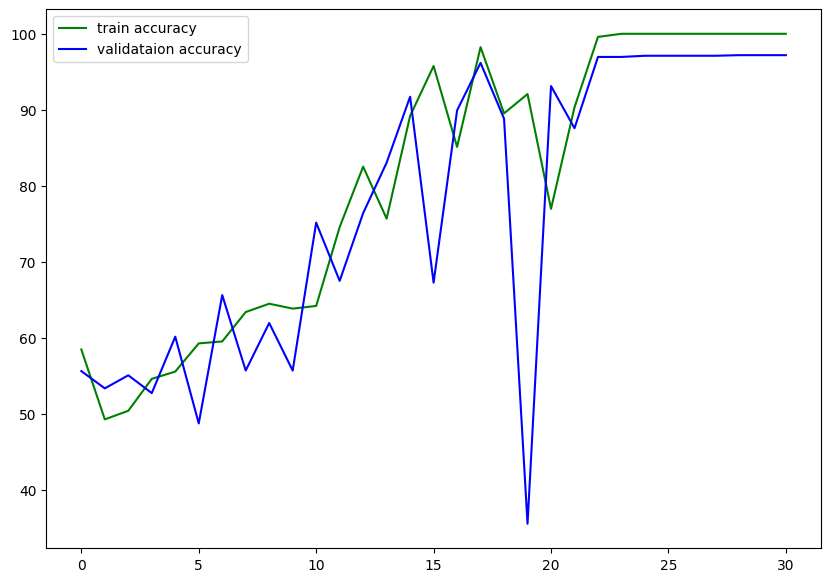

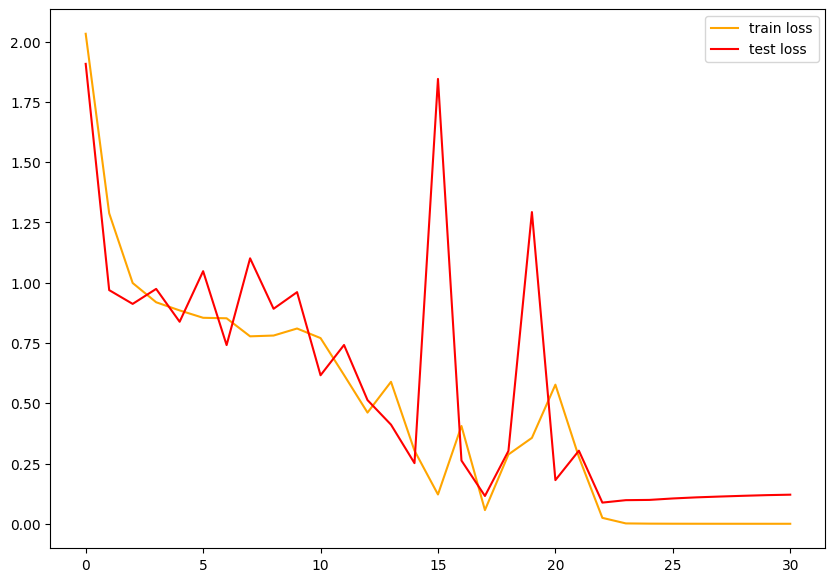

In [ ]:
## This class helps in classifying the alzheimer images with different severities.
from torchvision.models import resnet50, ResNet50_Weights, vgg16
import torch.nn.functional as F
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt

train_epoch_accuracy = []
test_epoch_accuracy = []
train_epoch_loss = []
test_epoch_loss = []
class AlzheimerImageClassification(object):
    def __init__(self, train_dl, test_dl, device):
        #self.data_loader = data_loader
        self.device = device
        self.train_dl = train_dl
        self.test_dl = test_dl

    def set_pre_trained_model(self, pre_model):
        torch.cuda.empty_cache()
        torch.manual_seed(8192)
        if pre_model == "resnet50":
            self.model = resnet50(pretrained=True)
        else:
            self.model = vgg16(pretrained=True)
        self.model.to(self.device)
        self.model.eval()

    def accuracy(self, out, labels):
        _,pred = torch.max(out, dim=1)
    # print(pred, labels)
        return torch.sum(pred==labels).item()


    def draw_accuracy_plot(self, train_epoch_accuracy, test_epoch_accuracy):
        plt.figure(figsize=(10, 7))
        plt.plot(train_epoch_accuracy, color='green', label='train accuracy')
        plt.plot(test_epoch_accuracy, color='blue', label='validataion accuracy')
        plt.legend()
        plt.savefig('accuracy.png')
        plt.show()

    def draw_loss_plot(self, train_epoch_loss, test_epoch_loss):
        plt.figure(figsize=(10, 7))
        plt.plot(train_epoch_loss, color='orange', label='train loss')
        plt.plot(test_epoch_loss, color='red', label='test loss')
        plt.legend()
        plt.savefig('loss.png')
        plt.show()


    def fit(self, epochs, lr,  start_idx=1, seed=8192):
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 128) #why 128
        self.model.fc = self.model.fc.cuda()
        torch.cuda.empty_cache()
        torch.manual_seed(seed)
        self.model = self.model.to(device)
        self.model.train()

    # Losses & scores
    # Create optimizers
        opt_d = torch.optim.Adam(self.model.parameters(), lr=lr, betas=(0.5, 0.999))
        for epoch in range(epochs):
            train_loss = 0
            train_running_accuracy = 0
            # Iterate and train the entire train data by batches, and calculate losses and accuracy.
            for real_images, labels in tqdm(self.train_dl):
                # Train discriminator
                opt_d.zero_grad()
                real_preds = self.model(real_images)
                real_targets = labels
                # print("real_preds, labels", real_preds, labels)
                #print(real_preds.shape, labels.shape)
                real_loss = F.cross_entropy(real_preds, real_targets)
                real_loss.backward()
                opt_d.step()
                train_loss += real_loss.item()
                sum = self.accuracy(real_preds, real_targets)
                # print("sum", sum)
                train_running_accuracy += sum
                # loss_d = train_discriminator(real_images, labels, opt_d)
            # real_scores.append(real_score)
            mean_train_loss = train_loss / len(self.train_dl)
            # print("train_dl length:", len(train_dl.dl.dataset))
            train_accuracy = 100 * (train_running_accuracy / len(self.train_dl.dl.dataset))
            train_epoch_accuracy.append(train_accuracy)
            train_epoch_loss.append(mean_train_loss)

            # Run the test data with the updated model in this epoch, and
            #calculates losses and accuracy.
            with torch.no_grad():
                self.model.eval()
                test_loss = 0
                test_running_accuracy = 0
                for data_t, target_t in tqdm(self.test_dl):
                    real_preds = self.model(data_t)

                    real_targets = target_t
                    loss = F.cross_entropy(real_preds, real_targets)
                    test_loss += loss.item()
                    test_running_accuracy += self.accuracy(real_preds, real_targets)
            mean_test_loss = test_loss / len(self.test_dl)
            test_accuracy = 100 * (test_running_accuracy / len(self.test_dl.dl.dataset))
            test_epoch_accuracy.append(test_accuracy)
            test_epoch_loss.append(mean_test_loss)

            # Log losses & scores (last batch)
            print("Epoch [{}/{}],  train loss: {:.4f}, train_accuracy: {:.4f}".format(
                epoch+1, epochs, mean_train_loss, train_accuracy))
            print("Mean Test loss: {:.4f}, test_accuracy: {:.4f}".format(mean_test_loss, test_accuracy))

            # Save generated images
            # save_samples(dir_idx, epoch+start_idx, fixed_latent, show=False)

        torch.save(self.model, "Alzheimer_Classification_Model")


lr = 0.0001
epochs = 31

alz_classification = AlzheimerImageClassification(dev_train_dl, dev_test_dl, device)
alz_classification.set_pre_trained_model("resnet50")
history = alz_classification.fit(epochs, lr)

alz_classification.draw_accuracy_plot(train_epoch_accuracy, test_epoch_accuracy)
alz_classification.draw_loss_plot(train_epoch_loss, test_epoch_loss)






In [ ]:
import torch.nn.functional as F
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
def noise(size):
    return torch.randn(size, 100, 1, 1, device=device).to(device)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, emb_size=32):
        super(Discriminator, self).__init__()
        self.emb_size = 32
        self.label_embeddings = nn.Embedding(4, self.emb_size)
        self.model = nn.Sequential(
            nn.Conv2d(3,64,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*2,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*4,64*8,4,2,1,bias=False),
            nn.BatchNorm2d(64*8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*8,64,4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Flatten()
        )
        self.model2 = nn.Sequential(
            nn.Linear(288,100),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(100,1),
            nn.Sigmoid()
        )
        self.apply(weights_init)
    def forward(self, input, labels):
        x = self.model(input)
        y = self.label_embeddings(labels)
        input = torch.cat([x, y], 1)
        final_output = self.model2(input)
        return final_output

In [ ]:
!pip install torch_summary
from torchsummary import summary
discriminator = Discriminator().to(device)

summary(discriminator,torch.zeros(32,3,64,64).to(device), torch.zeros(32).long().to(device));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256]                 --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          3,072
|    └─LeakyReLU: 2-2                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 128, 16, 16]         131,072
|    └─BatchNorm2d: 2-4                  [-1, 128, 16, 16]         256
|    └─LeakyReLU: 2-5                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-6                       [-1, 256, 8, 8]           524,288
|    └─BatchNorm2d: 2-7                  [-1, 256, 8, 8]           512
|    └─LeakyReLU: 2-8                    [-1, 256, 8, 8]           --
|    └─Conv2d: 2-9                       [-1, 512, 4, 4]           2,097,152
|    └─BatchNorm2d: 2-10                 [-1, 512, 4, 4]           1,024
|    └─LeakyReLU: 2-11                   [-1, 512, 4, 4]           --
|    └─Conv2d: 2-12                      [-1, 64, 2, 2]     

In [ ]:
# Implementing a conditional generator. It means generating a specific class of data
class Generator(nn.Module):
    def __init__(self, emb_size=32):
        super(Generator,self).__init__()
        self.emb_size = emb_size
        self.label_embeddings = nn.Embedding(4, self.emb_size)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100+self.emb_size,64*8,4,1,0,bias=False),
            nn.BatchNorm2d(64*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*8,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*4,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*2,64,4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,3,4,2,1,bias=False),
            nn.Tanh()
        )
        self.apply(weights_init)
    def forward(self,input_noise,labels):
        label_embeddings = self.label_embeddings(labels).view(len(labels), self.emb_size, 1, 1)
        input = torch.cat([input_noise, label_embeddings], 1)
        return self.model(input)

In [ ]:
generator = Generator().to(device)
summary(generator,torch.zeros(32,100,1,1).to(device), torch.zeros(32).long().to(device));

Layer (type:depth-idx)                   Output Shape              Param #
├─Embedding: 1-1                         [-1, 32]                  128
├─Sequential: 1-2                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           1,081,344
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,072
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 3

In [ ]:

def noise(size):
    n = torch.randn(size, 100, 1, 1, device=device)
    return n.to(device)

In [ ]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)
loss = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
fixed_fake_labels = torch.LongTensor([0]*(len(fixed_noise)//2) + [1]*(len(fixed_noise)//2)).to(device)
loss = nn.BCELoss()
n_epochs = 25
img_list = []

In [ ]:
# Training the Discriminator
def discriminator_train_step(real_data, real_labels, fake_data, fake_labels):
    d_optimizer.zero_grad()
    prediction_real = discriminator(real_data, real_labels)
    error_real = loss(prediction_real, torch.ones(len(real_data), 1).to(device))
    error_real.backward()
    prediction_fake = discriminator(fake_data, fake_labels)
    error_fake = loss(prediction_fake, torch.zeros(len(fake_data), 1).to(device))
    error_fake.backward()
    d_optimizer.step()
    return error_real + error_fake

In [ ]:
# Training the Generator
def generator_train_step(fake_data, fake_labels):
    g_optimizer.zero_grad()
    prediction = discriminator(fake_data, fake_labels)
    error = loss(prediction, torch.ones(len(fake_data), 1).to(device))
    error.backward()
    g_optimizer.step()
    return error

In [ ]:


import numpy as np
import torchvision.utils as vutils

!pip install -q --upgrade torch_snippets
from torch_snippets import *
# device = "cuda" if torch.cuda.is_available() else "cpu"
from torchvision.utils import make_grid
from torch_snippets import *
from PIL import Image
import torchvision
from torchvision import transforms
import torchvision.utils as vutils

# Getting Generatred images after training for specific number of epochs.
log = Report(n_epochs)
for epoch in range(n_epochs):
    N = len(alz_data_loader.data_batch)
    for bx, (images, labels) in enumerate(alz_data_loader.data_batch):

        real_data, real_labels = images.to(device), labels.to(device)
        fake_labels = torch.LongTensor(np.random.randint(0, 4, len(real_data))).to(device)
        fake_data = generator(noise(len(real_data)), fake_labels)
        fake_data = fake_data.detach()
        d_loss = discriminator_train_step(real_data, real_labels, fake_data, fake_labels)

        fake_labels = torch.LongTensor(np.random.randint(0, 4, len(real_data))).to(device)
        fake_data = generator(noise(len(real_data)), fake_labels).to(device)
        g_loss = generator_train_step(fake_data, fake_labels)
        pos = epoch + (1+bx)/N
    log.record(pos, d_loss=d_loss.detach(), g_loss=g_loss.detach(), end='\r')
    log.report_avgs(epoch+1)
    with torch.no_grad():
        fake = generator(fixed_noise, fixed_fake_labels).detach().cpu()
        vutils.save_image(fake, 'fake_samples_epoch_%03d.png' % (epoch + 1), normalize=True)

        imgs = vutils.make_grid(fake, padding=2, normalize=True).permute(1,2,0)
        img_list.append(imgs)
        show(imgs, sz=10)
torch.save(generator, 'generator.pth')
torch.save(discriminator, 'discriminator.pth')

In [ ]:
#TODO:
#Planning to use Wasserstein Conditional GANs for stability
#and run the output of the Generator on the Classification Model.
# Training the Discriminator

class Critic(nn.Module):
    def __init__(self, emb_size=32):
        super(Critic, self).__init__()
        self.emb_size = 32
        self.label_embeddings = nn.Embedding(4, self.emb_size)
        self.model = nn.Sequential(
            nn.Conv2d(3,64,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*2,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*4,64*8,4,2,1,bias=False),
            nn.BatchNorm2d(64*8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*8,64,4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Flatten()
        )
        self.model2 = nn.Sequential(
            nn.Linear(288,100),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(100,1)

        )
        self.apply(weights_init)
    def forward(self, input, labels):
        x = self.model(input)
        y = self.label_embeddings(labels)
        input = torch.cat([x, y], 1)
        final_output = self.model2(input)
        return final_output

generator = Generator().to(device)
critic = Critic().to(device)
optimizer_critic = optim.RMSprop(critic.parameters(), lr=0.00005)
optimizer_generator = optim.RMSprop(generator.parameters(), lr=0.00005)

def critic_train_step(real_data, real_labels, fake_data, fake_labels):
    optimizer_critic.zero_grad()
    prediction_real = critic(real_data, real_labels)
    prediction_fake = critic(fake_data, fake_labels)
    error = -torch.mean(prediction_real) + torch.mean(prediction_fake)
    error.backward()
    optimizer_critic.step()
     # Clip the critic weights (or use gradient penalty)
    for param in critic.parameters():
        param.data.clamp_(-0.01, 0.01)

    return error



# Training the Generator
def wass_generator_train_step(fake_data, fake_labels):
    optimizer_generator.zero_grad()
    prediction = critic(fake_data, fake_labels)
    error = -torch.mean(prediction)
    error.backward()
    optimizer_generator.step()
    return error



In [ ]:
log = Report(n_epochs)

for epoch in range(n_epochs):
    N = len(alz_data_loader.data_batch)
    for bx, (images, labels) in enumerate(alz_data_loader.data_batch):
        real_data, real_labels = images.to(device), labels.to(device)
        fake_labels = torch.LongTensor(np.random.randint(0, 4, len(real_data))).to(device)
        fake_data = generator(noise(len(real_data)), fake_labels)
        fake_data = fake_data.detach()
        d_loss = critic_train_step(real_data, real_labels, fake_data, fake_labels)
        fake_labels = torch.LongTensor(np.random.randint(0, 4, len(real_data))).to(device)
        fake_data = generator(noise(len(real_data)), fake_labels).to(device)
        g_loss = wass_generator_train_step(fake_data, fake_labels)
        pos = epoch + (1+bx)/N
    log.record(pos, d_loss=d_loss.detach(), g_loss=g_loss.detach(), end='\r')
    log.report_avgs(epoch+1)
    with torch.no_grad():
        fake = generator(fixed_noise, fixed_fake_labels).detach().cpu()
        vutils.save_image(fake, 'fake_samples_epoch_%03d.png' % (epoch + 1), normalize=True)

        imgs = vutils.make_grid(fake, padding=2, normalize=True).permute(1,2,0)
        img_list.append(imgs)
        show(imgs, sz=10)

In [ ]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    print(out, pred, labels)
    return torch.sum(pred==labels).item()

was_generator = torch.load('wass_enerator.pth')

labels = torch.LongTensor(np.random.randint(0, 4, len(real_data))).to(device)
data = was_generator(noise(len(real_data)), labels)
vutils.save_image(data, 'fake_samples_epoch_%03d.png' % (epoch + 1), normalize=True)
imgs = vutils.make_grid(data, padding=2, normalize=True).permute(1,2,0)
img_list.append(imgs)
plt.title(labels)
show(imgs, sz=10)
classifier = torch.load("Alzheimer_Classification_Model")

preds = classifier(data)
print(preds)
loss = F.cross_entropy(preds, labels)
test_loss = loss.item()
accuracy = accuracy(preds, labels)
print("test_loss", test_loss, "Accuracy:", accuracy)